## PHYS 481 Midterm

November 11, 2018

Kenneth Sharman (00300185)

In [1]:
'''Import standard packages'''
import numpy as np
import matplotlib.pyplot as plt


### Introduction

A noticeable distinction between PHYS 381 and 481 is that we now possess the skills required to solve some more in-depth problems in the field of physics. This report will be a mix of analytic and numeric problem solving and the solutions obtained will be compared to each other. It is not always the case the we can compare against a known solution. By going through exercises like this report, we gain experience in situations where the answer is known and that enables us to be more aware of potential trouble spots or pitfalls when solving other problems.

Many important and interesting phenomena are modelled by functions of several variables that satisfy certain _partial differential equations_. These equations can be divided into initial value problems and boundary value problems. We will study the equation known as __Laplace's Equation__, which is a boundary value problem. A classic example of Laplace's equation is the problem of solving for the electric potential in electrostatics.

__Electrostatics__

Consider two of the most important equations in electrostatics. The electric field $\vec{E}$ and the electrostatic potential $V$ are related by $\vec{E} = - \vec{\nabla} V $. The differential form of Gauss's Law relates the volume charge density $\rho$ $ \big[ \frac{C}{m^3} \big]$ and the electric field by $\vec{\nabla} \cdot \vec{E} = \frac{\rho}{\epsilon_0}$, where $\epsilon_0$ is the electric permittivity of free space ($\epsilon_0 = 8.85 \times 10^{-12}\; C/Vm$).

In the absence of any electric charges we have $\vec{\nabla} \cdot \vec{E} = 0 \Rightarrow - \vec{\nabla} \cdot \vec{\nabla} V $. Expressing this in terms of the Laplace operator, or the full cartesian partial derivatives,

$$ \nabla^2 V = 0 \qquad \Longleftrightarrow \qquad \frac{\partial^2 V}{\partial x^2} + \frac{\partial^2 V}{\partial y^2} +  \frac{\partial^2 V}{\partial z^2} = 0 $$

which are the classic representations of Laplace's equation. The beauty and simplicity of Laplace's equation in electrostatics is found in the _Uniqueness Theorem_ which states that the solution to Laplace's equation in some volume $\Omega$ is uniquely determined if $V$ is specified on the boundary surface $\text{S}$. Thus, we can be assured that if a solution is found that is consistent with the imposed boundary conditions, we need not go any further, as this is the one and only solution to our problem.

When we studied this topic in electromagnetism, we began with the one-dimensional case and worked our way up to higher dimensions. We will use the same process in this analysis.

__Task 1: Laplace 1D__

To begin, consider a system that independent of the cartesian $y$ and $z$ coordinates. The partial differential equation is dependent only on $x$ and assumes the form

$$  \frac{\partial^2 V}{\partial x^2} = 0 $$

Next, assume that the potential is known to have the following values at the boundary points

$$V(0) = 0 \qquad \text{and} \qquad V(1) = 1 $$

Solutions to Laplace's equation are known as harmonic functions. These functions have no local maxima or minima. In PHYS 455 we learned that this is equivalent to stating that $V(x)$ is the average of $V(x+a)$ and $V(x-a)$ for any $a$:

$$ V(x) = \frac{1}{2} \Big[ V(x+a) + V(x-a) \Big] $$

This result is a direction consequence of the method of finite differences, which approximates the value of a nth-order derivative using the Taylor Series expansion of that function.

To determine the solution, we will use __The Relaxation Method__, which simply iterates the average value function. An initial guess is made of the unknown variable $V(x)$, then this value is plugged into the right-hand side of the equation to get a new value for $V(x)$. The process is repeated until $V(x)$ settles down to some fixed value. It has been proved$^1$ that this approach for solving the Laplace equation, also known as the __Jacobi Method__, is numerically stable and always gives a solution (this statement is questioned in part 2).

We will setup a one-dimensional array, representing the points of our system, initialize the endpoints with the given boundary conditions, and iterate the relaxation method until the potential at each point stops changing within some limit of tolerance. Note that this method implicitly assumes that the relaxation method approaches the solution relatively quickly (which is not guaranteed to be true). To implement this in code, a class will be defined with the appropriate attributes.

In [2]:
'''Implement class for case of 1D Laplace Equation'''
class ElectricPotential1D:
    '''
    Class represents a 1D electrostatic system, where interior points are found by
    solving Laplace's equation using the method of relaxation.
    '''
    def __init__(self, left_point, right_point, left_bound_val, right_bound_val, grid_size, tol):
        '''
        Constructor initializes all instances variables and sets boundary conditions
        Parameters:
            left_point, right_point: x location for left and right boundaries (SI units: m)
            left_bound_val, right_bound_val: Electruic potential at boundaries (SI units: V)
            grid_size: Size of 1D array
            tol: Tolerance required to terminate relaxation method
        '''
        self.x_vals = np.linspace(left_point, right_point, grid_size) # array of x values
        self.v_vals = np.zeros(grid_size) # initial guess of V values
        self.target = tol # Relaxation tolerance limit

        # Set boundary conditions
        self.__init__set_boundary_conditions(left_bound_val, right_bound_val)

    def __init__set_boundary_conditions(self, left_bound_val, right_bound_val):
        '''
        Initializes the boundary conditions specified during instantiation
        Parameters:
            left_bound_val, right_bound_val: Electric potential at boundaries (SI units: V)
        '''
        self.v_vals[0] = left_bound_val # V[0] = left boundary conditions
        self.v_vals[-1] = right_bound_val # V[1] = right boundary condition

    def iterate_relaxation(self, plot=False):
        '''
        Iterates the relaxation method until solution varies by less than target tolerance
        Parameters:
            plot: if True solution and iteration count are added to a return list every 1000
            iterations. Default is False
        Returns:
            if plot==False: numbers of iterations required for specified target tolerance
            else: solution and count number after every 1000 iterations
        '''
        count, delta, return_list = 0, 1.0, [] # Initialize variables used in while loop
        v_prime = np.empty(len(self.v_vals)) # Empty list for relaxation method solution

        # Loop calculates the average value of both neighbors for every point. The boundary
        # points are set to boundary values. The (new) calculated solution becomes the (old)
        # solution in the next iteration by swapping array values after calculation is complete
        # The max difference in new and old solutions is compared against target tolerance.
        # Loop is broken when this difference is less than or equal to target.
        while delta > self.target:
            v_prime[0], v_prime[-1] = self.v_vals[0], self.v_vals[-1] # set boundary vals
            v_prime[1:-1] = (self.v_vals[0:-2] + self.v_vals[2:]) / 2.0 # avg of neighbors
            self.v_vals, v_prime = v_prime, self.v_vals # Swap new and old values
            delta = max(abs(self.v_vals - v_prime)) # max difference for all points

            # For every 1000 iterations add solution and iteration number to return list
            if (count % (1000) == 0) and plot == True:
                return_list.append([np.copy(self.v_vals), count])

            count += 1 # Increment iteration count
            
        return return_list if plot == True else count


To verify that the code is working as intended we will run a simple test. Suppose we have a one-dimensional system with boundary values of $V(0)=10$ and $V(5)=10$. Since Laplace's equation tolerates no local maxima or minima, we expect the solution to simply be $V(x)=10$. The following code defines a test function that determines if the ElectricPotential_1D class is consistent with this expected solution.

In [3]:
'''Simple Test of ElectricPotential_1D class'''
def test_electric_potential_onedim():
    '''Assertion check of difference between computed and analytical solutions'''
    test_system = ElectricPotential1D(0.0, 5.0, 10.0, 10.0, 10, 1e-5)
    test_system.iterate_relaxation()
    expected = [10.0]*len(test_system.v_vals)
    assert max(abs(test_system.v_vals - expected)) < 0.02

test_electric_potential_onedim()


It was found that our system is consistent with expectations, to within 0.02, given that the relaxation method terminated after the solutions were varying less than 1e-5 between iterations. I had to change the assertion tolerance (actually had to print out the maximum difference) to determine exactly what was going on, as I had initially mistaken the relaxation tolerance to be the accuracy of the solution (good thing I did the test!). This test demonstrated that indeed the class is consistent with expectations, but it has also highlighted the issue of determining how accurate these solutions are.

The analytic solution to Task 1 is easily obtained so we can compare it with the solutions obtained after a certain number of iterations, to get an idea of the error involved. Determining the analytic solution,

$$  \frac{\partial^2 V}{\partial x^2} = 0 \qquad\Longrightarrow\qquad \frac{\partial V}{\partial x} = constant $$

$$ \therefore \qquad V(x) = ax + b \qquad \text{where a and b are constants} $$

$$ V(0) = a(0) + b = 0 \qquad \therefore \qquad b = 0 $$

$$ V(1) = a(1) + 0 = 1 \qquad \therefore \qquad a = 1 $$

$$ V(x) = x $$

The solutions generated after various relaxation iterations will be plotted along with a plot of the corresponding errors involved.

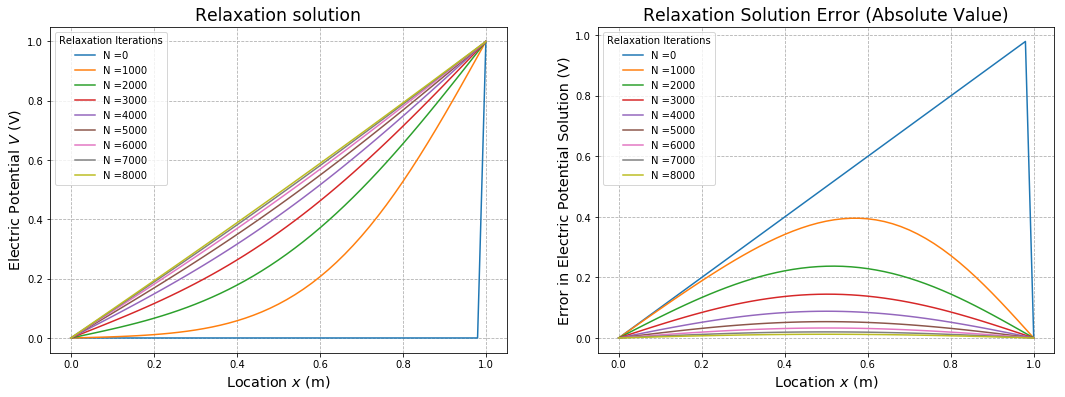

In [4]:
'''Plot Relaxation Solutions and Corresponding Errors'''
# Instantiate the 1D system
one_dim_system = ElectricPotential1D(0.0, 1.0, 0.0, 1.0, 101, 1e-5)
nstep_solns = one_dim_system.iterate_relaxation(True) # Store solns/ counts

plt.figure(figsize=(18, 6)) # Set the plot size
ax1, ax2 = plt.subplot(1, 2, 1), plt.subplot(1, 2, 2) # Create 2 subplots

# Plot solutions and errors in solutions
for soln in nstep_solns:
    ax1.plot(one_dim_system.x_vals, soln[0], label='N =' + str(soln[1]))
    ax2.plot(one_dim_system.x_vals, abs(soln[0]-one_dim_system.x_vals), label='N =' + str(soln[1]))

# Customize first subplot
ax1.legend(title='Relaxation Iterations')
ax1.set_xlabel('Location $x$ (m)', fontsize='x-large')
ax1.set_ylabel('Electric Potential $V$ (V)', fontsize='x-large')
ax1.set_title('Relaxation solution', fontsize='xx-large')
ax1.grid(linestyle='dashed') # Add grid with dashed lines to graph

# Customize second subplot
ax2.legend(title='Relaxation Iterations')
ax2.set_xlabel('Location $x$ (m)', fontsize='x-large')
ax2.set_ylabel('Error in Electric Potential Solution (V)', fontsize='x-large')
ax2.set_title('Relaxation Solution Error (Absolute Value)', fontsize='xx-large')
ax2.grid(linestyle='dashed') # Add grid with dashed lines to graph

plt.show()


It comes as no surprise that the error associated with a solution is reduced for an increased number of iterations of the relaxation method. From the solution plot; it is clear that a large number of iterations are required for the interior points to converge to the known solution. We should then, select the largest number of iterations possible. This value is dependent on how much time we can allocate to this computation.

Recall that the relaxation method terminates when the solutions, after each iteration, no longer vary by a desired tolerance. We can investigate the runtime complexity by plotting both the number of iterations and the runtime required to obtained the given tolerance. 

In [5]:
'''Calculate Number of Iterations Required for Relaxation Tolerances'''
TOLERANCES = np.geomspace(1e-10, 1, num=11) # Array of relaxation tolerances
iteration_counts = [] # List for iterations required to obtain soln within tolerance

# For each tolerance, add the number of iterations required to a list used for plotting
for tol in TOLERANCES:
    elecstatic_system = ElectricPotential1D(0.0, 1.0, 0.0, 1.0, 101, tol)
    iteration_counts.append(elecstatic_system.iterate_relaxation())


In [6]:
'''Evaluate Runtimes Required for Relaxation Tolerances'''
import timeit #Import timeit package to evaluate runtimes

run_times = [] # Lists for average runtimes

# For each tolerance, determine add runtime required to a list used for plotting
for tol in TOLERANCES:
    elecstatic_system = ElectricPotential1D(0.0, 1.0, 0.0, 1.0, 101, tol)
    run_times.append(timeit.timeit(elecstatic_system.iterate_relaxation, number=1000))


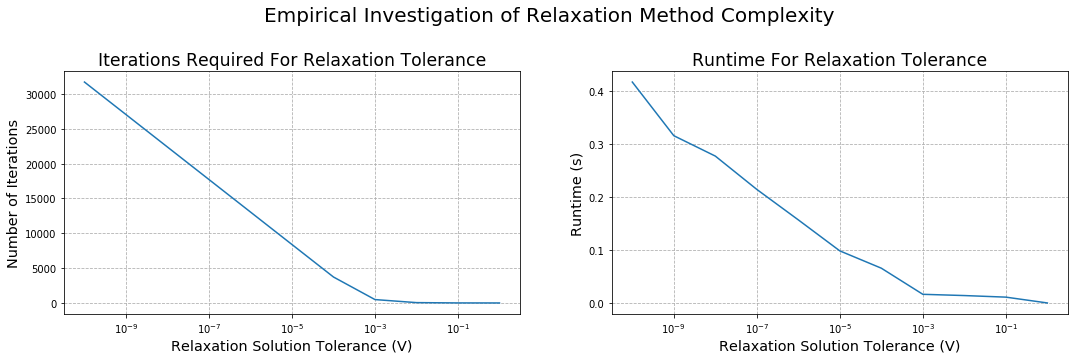

In [7]:
'''Plot Iterations and Runtimes Required for Relaxation Tolerances'''
plt.figure(figsize=(18, 5)) # Set the plot size
# Add super-title to both subplots
plt.suptitle('Empirical Investigation of Relaxation Method Complexity', fontsize=20)
ax1, ax2 = plt.subplot(1, 2, 1), plt.subplot(1, 2, 2) # Create 2 subplots

# Plot iterations required for relaxation tolerances
ax1.plot(TOLERANCES, iteration_counts)
ax1.set_xscale('log') # Semi log scale
ax1.set_xlabel('Relaxation Solution Tolerance (V)', fontsize='x-large')
ax1.set_ylabel('Number of Iterations', fontsize='x-large')
ax1.set_title('Iterations Required For Relaxation Tolerance', fontsize='xx-large')
ax1.grid(linestyle='dashed') # Add grid with dashed lines to graph

# Plot runtime required for relaxation tolerances
ax2.plot(TOLERANCES, run_times)
ax2.set_xscale('log') # Semi log scale
ax2.set_xlabel('Relaxation Solution Tolerance (V)', fontsize='x-large')
ax2.set_ylabel('Runtime (s)', fontsize='x-large')
ax2.set_title('Runtime For Relaxation Tolerance', fontsize='xx-large')
ax2.grid(linestyle='dashed') # Add grid with dashed lines to graph

plt.subplots_adjust(top=0.80)
plt.show()


It may not come as a surprise that both plots have a very similar shape. This highlights the fact that this method is quite impractical if solutions are required to a high degree of accuracy; there is no hope that the algorithm will perform any better as the tolerance is decreased.

Since these are semi log plots, we note that past roughly three decimal places, the algorithms' complexity increases exponentially as the tolerance is decreased. The relaxation method is extremely simple to implement, and solutions converge relatively quickly for one or two decimal places, however a faster method would usually be necessary if higher degrees of accuracy were required.

__Task 2__:
Obtain a numerical solution to Laplace's equation in 2D for Griffiths example 3.4 and compare to the analytic result.

__Griffith Example 3.4__

Two infinitely long grounded metal plates lie parallel to the $x-z$ plane, one at $y=0$, the other at $y=a=5~cm$.  They are connected at $x=\pm b=\pm 4~cm$ by metal strips maintained at a constant potential $V_0=4~volts$ to form a rectangular channel.  A thin layer of insulation at each corner allows the sides to be maintained at different potentials.

A solution to this boundary value problem can be obtained through separation of variables

$$ V(x,y) = \frac{4 V_0}{\pi} \sum_{n=1,3,5,...} \frac{1}{n} \frac{\cosh(n \pi x / a)}{\cosh (n \pi b / a)} \sin(n \pi y / a)$$
 
We will implement a class for the two-dimensional system, in a very similar way to the one-dimensional case. In order to visualize the solution, a three-dimensional plot is necessary. Through experimentation, it has been found that the mpl_toolkits package offers a good solution to this task.

In [8]:
'''Import package used for 3D plots'''
from mpl_toolkits import mplot3d


In [9]:
'''Implement class for case of 2D Laplace Equation'''
class ElectricPotential2D:
    '''
    Class represents a 2D electrostatic system, where interior points are found by
    solving Laplace's equation using the method of relaxation.
    '''
    def __init__(self, xmin, xmax, ymin, ymax, xmin_b, xmax_b, ymin_b, ymax_b, grid_shape, tol):
        '''
        Constructor initializes all instances variables and sets boundary conditions
        Parameters:
            xmin, xmax, ymin, ymax: Values of independent variables at boundaries
            xmin_b, xmax_b, ymin_b, ymax_b: Values of dependent variable at boundaries
            grid_size: Size of 2D array, expressed as a 2-tuple, (x size, y size)
            tol: Tolerance required to terminate relaxation method
        '''
        self.nx, self.ny = grid_shape # Unpack x and y sizes
        # Create 2D array representing x and y coordinates of the system
        self.x, self.y = np.meshgrid(np.linspace(xmin, xmax, self.nx), \
                                     np.linspace(ymin, ymax, self.ny))
        self.v = np.zeros([self.nx, self.ny], float) # Initialize V(x,y) = 0 for all (x,y)
        # Store boundary conditions as class attributes
        self.xmin_b, self.xmax_b, self.ymin_b, self.ymax_b = xmin_b, xmax_b, ymin_b, ymax_b
        self.target = tol # Relaxation tolerance limit
        self.count = 0 # Number of relaxation iterations

        # Set boundary conditions
        self.__init__set_boundary_conditions()

    def __init__set_boundary_conditions(self):
        '''
        Initializes the boundary conditions specified during instantiation
        '''
        self.v[:, 0], self.v[:, -1] = self.xmin_b, self.xmax_b # Set x boundary conditions
        self.v[0, :], self.v[-1, :] = self.ymin_b, self.ymax_b # Set y boundary conditions

    def iterate_relaxation(self):
        '''
        Iterates the relaxation method until solution varies by less than target tolerance
        '''
        v_prime = np.empty([self.nx, self.ny], float) # Empty array for relaxation method solution
        delta = 1.0 # Initalize solution difference to a "large" value

        # Loop performs relaxation method calculation. New solution is average
        # of 4 closest neighbors. At beginning of loop the boundary conditions
        # are set. At end of loop the new and old solutions are swapped, so next
        # iteration uses new solution as old solution. Loop ends when the new and
        # old solutions differ by less than target amount
        while delta > self.target:
            # set boundary vals
            v_prime[:, 0], v_prime[:, -1] = self.v[:, 0], self.v[:, -1]
            v_prime[0, :], v_prime[-1, :] = self.v[0, :], self.v[-1, :]
            v_prime[1:-1, 1:-1] = (self.v[0:-2, 1:-1] + self.v[2:, 1:-1] \
                + self.v[1:-1, 0:-2] + self.v[1:-1, 2:]) / 4.0 # avg of neighbors
            self.v, v_prime = v_prime, self.v # Swap new and old values
            delta = np.amax(abs(self.v-v_prime)) # Update delta
            self.count += 1

    def plot_potential(self, title):
        '''
        Function generates a 3D plot of the potential over domain of x-y values using
        mpl_toolkits package
        Parameter title: Plot title
        '''
        fig = plt.figure(figsize=(25, 8)) # Set figure size
        ax = plt.axes(projection='3d') # 3D plot
        
        # plot_surface parameters determined by experimentation to give best output
        ax.plot_surface(self.x, self.y, self.v, rcount=25, ccount=25, cmap='winter') # Plot V(x,y)
        
        # Customize plot
        ax.set_xlabel('\nx Location (m)', fontsize=20)
        ax.set_ylabel('\ny Location (m)', fontsize='xx-large')
        ax.set_zlabel('Electric Potential (V)', fontsize=20, labelpad=15)
        ax.set_title(title, fontsize=30)
        
        plt.show()


As a preliminary test to see how the code is functioning, let's plug in the values of the Griffiths problem and see what we get. Remember that solutions to Laplace's equation must have no local minima or maxima.

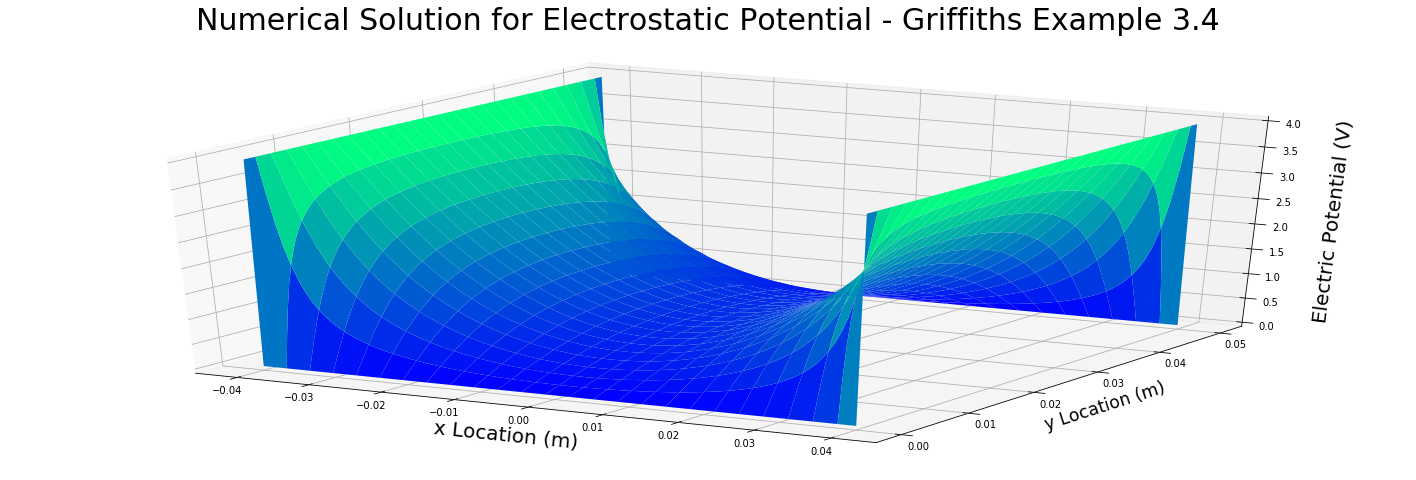

In [10]:
'''Instantiate System Specified by Griffiths 3.4'''
A, B, V0 = 0.05, 0.04, 4.0 # Example 3.4 parameters: a=5cm, b=4cm, V_0=4V

# The reason for using tol = 6e-4 is explained below
two_dim_system = ElectricPotential2D(-B, B, 0, A, V0, V0, 0.0, 0.0, \
                                     grid_shape=(100, 100), tol=6e-4)
two_dim_system.iterate_relaxation() # Run relaxation method
two_dim_system.plot_potential(title='Numerical Solution for Electrostatic Potential - ' \
                              + 'Griffiths Example 3.4\n') # Plot V(x,y) solution


The solution appears to have satisfied the condition that the interior points have no local maxima or minima. It is important to point out that the middle point, i.e. $(x,y) = (0.0~cm, 2.5~cm)$ is in fact a saddle point, not a local minima. This was a point of confusion for me when we first looked at harmonic functions in the Electromagnetism course.

The plot of the solution provided in Griffiths appears to be very similar, however a quantitative comparison is in order. To do so, it is necessary to define a function that evaluates analytical solution (shown above).

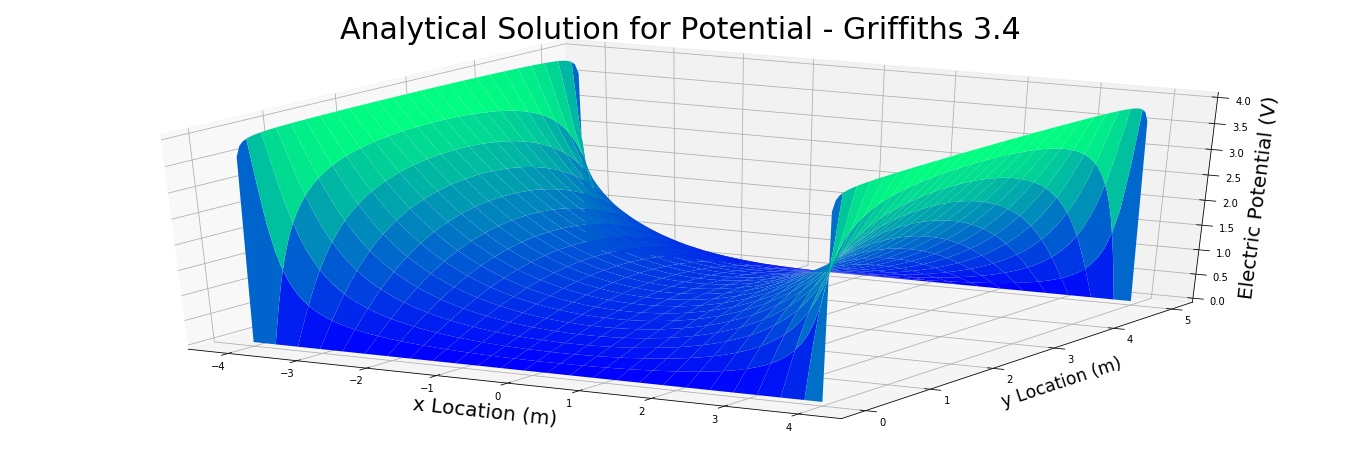

In [11]:
'''Define Function for Analytical Solution to Griffiths Example 3.4'''
def analytical_solution(V0, a, b, shape, plot=False):
    nx, ny = shape
    x,y = np.meshgrid(np.linspace(-b,b,nx),np.linspace(0,a,ny))
    V = np.zeros([nx, ny], float)
    for n in range(1,200,2):
        V += (1.0/n)*(np.cosh(n*np.pi*x/a))*(np.sin(n*np.pi*y/a)*(1/np.cosh(n*np.pi*b/a)))
    V *= 4.0*V0/np.pi
    
    if plot == True:
        fig = plt.figure(figsize = (24,8))
        ax = plt.axes(projection = '3d')
        ax.plot_surface(x, y, V, rcount=25, ccount=25, cmap = 'winter')
        ax.set_xlabel('\nx Location (m)', fontsize=20)
        ax.set_ylabel('\ny Location (m)', fontsize='xx-large')
        ax.set_zlabel('Electric Potential (V)', fontsize=20)
        ax.set_title('Analytical Solution for Potential - Griffiths 3.4', fontsize=30)

    else:
        return V
    
# Plot analytical solution
analytical_solution(V0=4.0, a=5.0, b=4.0, shape=(100,100), plot=True)


The first thing to note is that the analytical solution plot appears to be quite similar to that of the numerical, with the exception of the corners. The analytical potential has rounded corners, unlike the numerical. To quantize the difference, we will simply subtract the solutions. Since we will be computing the error various times throughout this report, a function is defined for this purpose.

In [12]:
'''Define function that computes error in solution'''
def error_in_potential(numerical_sol, analytical_sol, plot=False, title=''):
    '''
    Function calculates the absolute difference of parameters
    Parameters:
        numerical_sol: Array representing numerical solution potential
        analytical_sol: Array representing analytical solution potential
        plot: If true plots that difference error. Default is False
        title: Plot title
    Returns absolute difference in solutions if plot == False
    '''
    
    error = abs(numerical_sol - analytical_sol)
    
    if plot == True:
        fig = plt.figure(figsize=(24, 8))
        ax = plt.axes(projection='3d')

        ax.plot_surface(two_dim_system.x, two_dim_system.y, error, rcount=25, \
                        ccount=25, cmap='winter')

        ax.set_xlabel('\nx Location (m)', fontsize=20)
        ax.set_ylabel('\ny Location (m)', fontsize='xx-large')
        ax.set_zlabel('Electric Potential (V)', fontsize=20, labelpad=20)
        ax.set_title(title, fontsize=30)
        
        plt.show()
        
        max_error = np.amax(error)
        print('Maximum Difference in Analytical and Numerical Solutions =', np.round(max_error, 6), 'V')
        
    else:
        return error


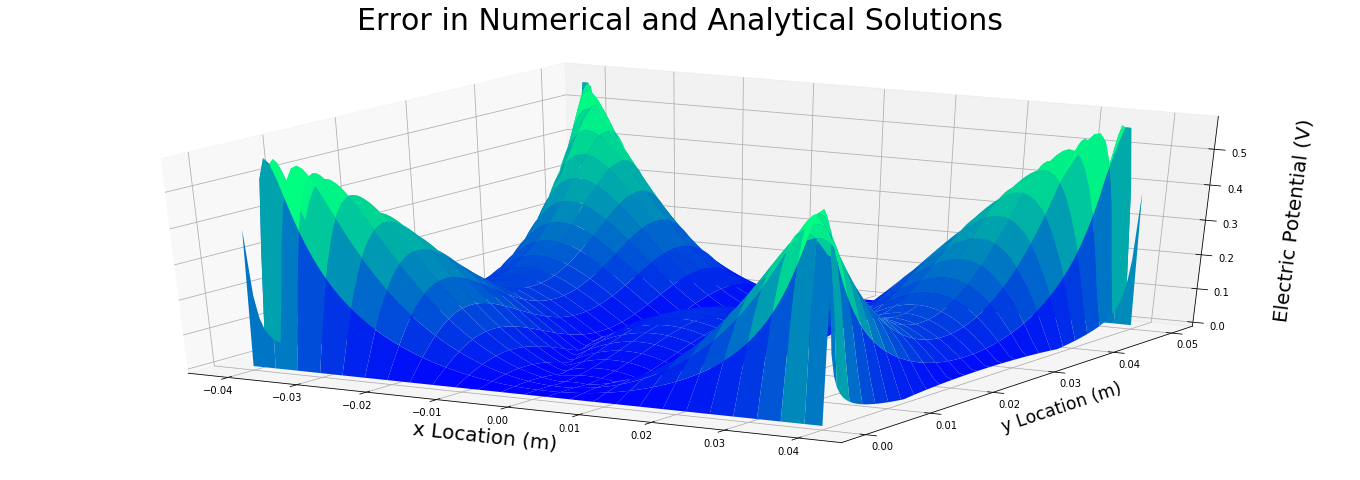

Maximum Difference in Analytical and Numerical Solutions = 0.578553 V


In [13]:
'''Determine the Error in Numerical and Analytical Solution of Griffiths Example 3.4'''

# Plot error
error_in_potential(two_dim_system.v, analytical_solution(V0=4.0, a=5.0, b=4.0,\
    shape=(100, 100)), plot=True, title='Error in Numerical and Analytical Solutions\n')


The plot of the error is consistent with the previous plots of both solutions, in that we noticed that corners appear to be quite different. Remember that the relaxation method is terminated once the solutions stop changing by a set tolerance. In theory, by increasing this tolerance we expect to produce a solution close to the analytical.

We will instantiate a second ElectricPotential2D object that is identical to the first, expect the tolerance is smaller.

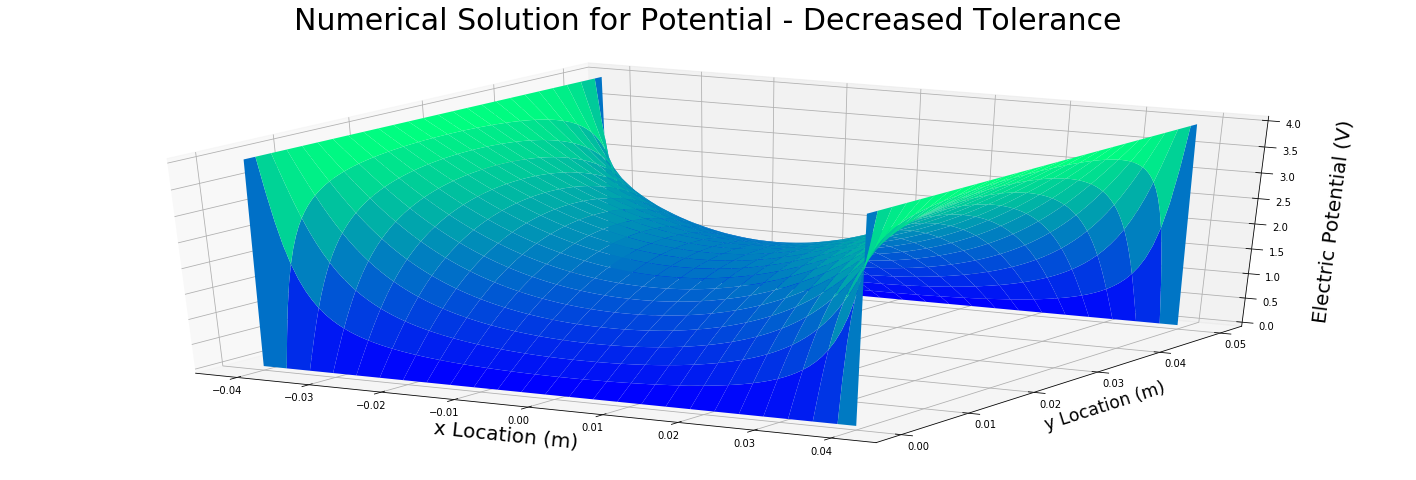

In [14]:
'''Decrease Relaxation Method Tolerance and Plot Solution'''
two_dim_system2 = ElectricPotential2D(-B, B, 0, A, V0, V0, 0.0, 0.0, grid_shape=(100, 100), tol=1e-10)
two_dim_system2.iterate_relaxation() # Iterate relaxation method
two_dim_system2.plot_potential(title='Numerical Solution for Potential - ' \
                              + 'Decreased Tolerance\n') # plot solution


Making a quick visual comparison with the analytical plot, the results are quite surprising. Earlier, we saw that the interior points had relatively low error, but now the potential in the interior has increased by a significant amount. Let's run the error function to quantize this result.

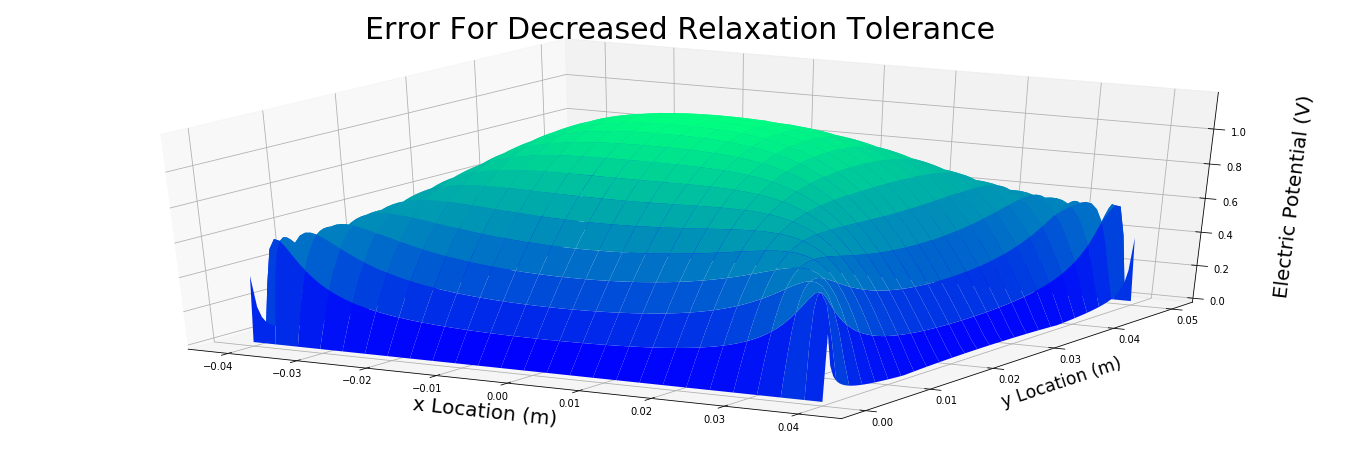

Maximum Difference in Analytical and Numerical Solutions = 1.181932 V


In [15]:
'''Determine the Error for Decreased Relaxation Tolerance'''
# Plot error
error_in_potential(two_dim_system2.v, analytical_solution(V0=4.0, a=5.0, b=4.0,\
    shape=(100, 100)), plot=True, title='Error For Decreased Relaxation Tolerance')


Indeed, the results are counter-intuitive. It was expected that by decreasing the tolerance, this would allow the relaxation method to iterate longer, which in turn should produce a solution that is closer to the expected analytical value. Instead, the potential of the interior points appear to have diverged from expectations.

This indicates that the ElectricPotential2D class may not be implemented correctly, specifically the relaxation function. To test this hypothesis, we will test it on a simple case. Suppose the two-dimensional system is the same as above, expect that all boundary conditions are $V_0=4.0 \;V$. Since the solutions to Laplace's equation tolerate no local extrema, it is easy to see that the solution must be $V=4.0\;V$ for all $(x,y)$. Let's check this expectation with the error function.

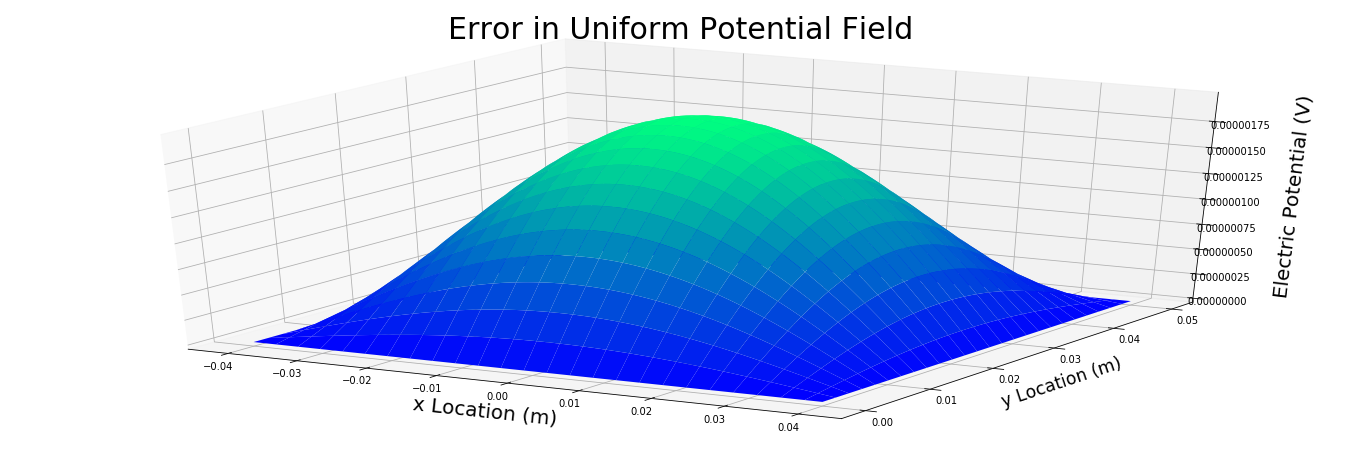

Maximum Difference in Analytical and Numerical Solutions = 2e-06 V


In [16]:
'''Test Hypothesis for uniform potential'''
V0 = 4.0 # V=V0 for all boundaries
uniform_sys = ElectricPotential2D(-B, B, 0, A, V0, V0, V0, V0, (100, 100), 10e-10)
uniform_sys.iterate_relaxation()

# Plot error
error_in_potential(uniform_sys.v, 4.0, plot=True, title='Error in Uniform Potential Field')


Although the error plot looks like we are off track, we see that the maximum error is $2e-6 V$ which is relatively small. Further, the error is largest at the interior, as expected (since we are specifying the boundary conditions).

So, if the class is working as expected, what exactly is going on with the solution to Griffiths example 3.4? By plotting the errors associated with a range of relaxation tolerances, we can get an idea where the numerical solution starts to diverge from the analytical.

In [17]:
'''Calculate Error Associated with Range of Relaxation Tolerances'''
analytical_sol = analytical_solution(V0, A, B, (100, 100))

TOLERANCES = np.linspace(1e-4, 1e-3, 15)
error_list, count_list = [], []

for tol in TOLERANCES:
    numerical_sol = ElectricPotential2D(-B, B, 0, A, V0, V0, 0.0, 0.0, (100, 100), tol)
    numerical_sol.iterate_relaxation()
    error_list.append(np.amax(abs(analytical_sol - numerical_sol.v)))
    count_list.append(numerical_sol.count)


In [18]:
'''Import Pandas package for table creation'''
import pandas as pd

DF1 = pd.DataFrame({
    'Count': count_list,
    'Error': error_list,
    'Tolerance': TOLERANCES
})

print('Errors Corresponding to Relaxation Tolerances')
print(DF1)


Errors Corresponding to Relaxation Tolerances
    Count     Error  Tolerance
0    5546  0.983446   0.000100
1    4560  0.856389   0.000164
2    3902  0.736597   0.000229
3    3405  0.625194   0.000293
4    3003  0.588032   0.000357
5    2658  0.585229   0.000421
6    2349  0.582898   0.000486
7    2053  0.580745   0.000550
8    1730  0.577734   0.000614
9    1418  0.576333   0.000679
10   1262  0.576107   0.000743
11   1153  0.575916   0.000807
12   1067  0.575737   0.000871
13    996  0.610913   0.000936
14    935  0.645104   0.001000


We see that a larger number of iterations is required for a lower relaxation tolerance. However, we reach a critical tolerance, roughly 7e-4 V, where the error is minimized. For tolerances below this point, the error increases, which is best visualized on a plot.

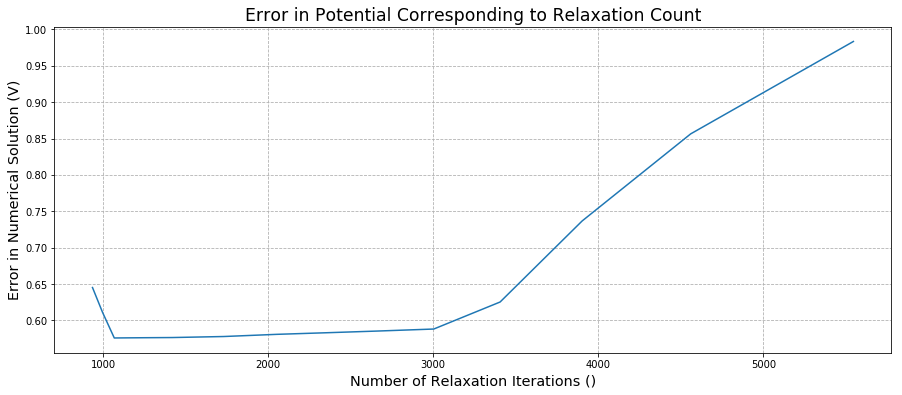

In [19]:
'''Plot Solution Error for Relaxation Iterations'''
plt.figure(figsize=(15, 6)) # Set the plot size

plt.plot(count_list, error_list)

# Customize first subplot
plt.xlabel('Number of Relaxation Iterations ()', fontsize='x-large')
plt.ylabel('Error in Numerical Solution (V)', fontsize='x-large')
plt.title('Error in Potential Corresponding to Relaxation Count', fontsize='xx-large')
plt.grid(linestyle='dashed') # Add grid with dashed lines to graph


It appears that the relaxation method does not converge to the expected solution for repeated iterations. This contradicts the information I have read which states that the method has been proved to converge to the solution$^1$.

I tried to come up with reasons as to why this divergence was occurring. An initial hypothesis was that the finite number of terms used in the summation in the analytical solution was not a good approximation for the infinite sum that the solution calls for. The problem here, is that for larger values, the $cosh$ function easily throws an overflow exception. To overcome this problem the mpmath package was utilized. The following code represents my attempt at calculating a better approximation to the analytical solution. The code does not need to be run, because as it turns out, the approximation used is equivalent up to three decimal places for $V(0.0~cm, 2.5~cm)$ and the output gets us no closer to answering this puzzle. However, I thought I would present the code to illustrate my thought process.

<pre>
from mpmath import *

def mp_soln(a=5, b=4, size=10):
    '''
    Function computes analytical solution to Griffiths 3.4 using the high precision
    mpmath package to evaluate a large number of terms in the infinite summation
    '''
    x = np.array([mpf(x) for x in np.linspace(-b,b,size)])
    y = np.array([mpf(y) for y in np.linspace(0,a,size)])
    z = np.zeros([size,size], dtype=mpf)
    for i in range(len(x)):
        for j in range(len(y)):
            z[i][j] = 0
            for n in range(1,1000,2):
                z[i][j] += (1.0/n)*(mp.cosh(n*np.pi*x[i]/a))*(mp.sin(n*np.pi*y[j]/a)*(1/mp.cosh(n*np.pi*b/a)))
            z[i][j] = 16.0/np.pi * float(z[i][j])
    return z
</pre>

After some more digging around it appears that the relaxation method, specifically the Jacobi method, only guarantees convergence for particular types of problems$^2$. When the problem is expressed in matrix form, convergence is only guaranteed for _positive-definite type_ matrices. Unfortunately, due to time constraints, I will not be perusing the matrix form representation of this problem, but it is somewhat assuring to know that initial assumption, regarding absolute convergence, was off track.

It is important to note that the relaxation method implemented here, does indeed provide a method for numerically solving Griffiths example 3.4 up to a certain tolerance- which can only be determined if the analytical solution is known. Clearly, this is not ideal, however this exercise has shown that we cannot simply assume that certain methods are going to do what they are supposed to do. Attention must be paid when interpreting the results of computational analysis.

### Task 3:
A coaxial cable has inner conductor radius of $r_a=1~mm$ and outer conductor radius of $r_b=5~mm$.  Assume that the outer conductor is grounded, and the inner conductor is at potential $V_0=9~volts$.

Obtain a numerical solution to Laplace's equation in the region between the inner and outer conductors.  Plot and discuss.

What is the potential midway between the inner and outer conductors (at $r=3~mm$)?

Note that this problem is independent of both theta and z (if we assume the cable has infinite length). Laplace's equation in cylindrical coordinates, independent of $z$ and $\theta\;$ is:

$$ \nabla^2 V = 0 \qquad \Longleftrightarrow \qquad \frac{\partial^2 V}{\partial s^2} + \frac{1}{s} \frac{\partial V}{\partial s} = 0 $$

Expressing this in terms of finite differences, where $a$ is the spacing of the grid points:

$$ \frac{\partial^2 V_s}{\partial s^2} = \frac{V_{s+a} - 2V_{s} + V_{s-a}}{a^2} \qquad \text{and} \qquad \frac{1}{s} \frac{\partial V}{\partial s} = \frac{1}{s} \frac{V_{s+a} - V_{s-a} }{2a} $$

Rearranging for $V_s$:

$$ V_s = \frac{V_{s+a} + V_{s-a}}{2} + a\frac{V_{s+a} - V_{s-a}}{4s} $$

We will use the method of relaxation with this formula to obtain a solution to this problem.

Before we implement the code, it would be wise to present the analytical solution, for which we can compare against. The Laplacian in cylindrical coordinates can also be presented in the following form (easier to solve):

$$ \nabla^2 V = \frac{1}{s} \frac{\partial}{\partial s} \Big( s \frac{\partial V}{\partial s} \Big) = 0 $$

Thus,

$$ s \frac{\partial V}{\partial s} = constant \qquad \Longrightarrow \qquad V = c_1 ln(s) + c_2 \qquad c_1,\; c_2 \;\text{are constants}$$

Using the boundary conditions $V(s_a) = V_0$ and $V(s_b) = 0$ we can solve for the solution:

$$ V(s) = \frac{V_0}{ln \Big( \frac{s_a}{s_b} \Big) } \Big[ ln(s) - ln(s_b) \Big] $$

Similar to the first two questions, a class will be defined, and the resultant output will be compared against the analytical solution.

In [20]:
'''Implement class for case of 1D Cylindrical Laplace Equation'''
class CoaxialCable:
    '''
    Class represents a 1D electrostatic system in cylindrical coordiantes,
    where interior points are found by solving Laplace's equation using the
    method of relaxation.
    '''
    def __init__(self, s_a, s_b, V_a, V_b, grid_size, tol):
        '''
        Constructor initializes all instances variables and sets boundary conditions
        Parameters:
            s_a, s_b = s-coordinates representing the inner and outer radii of cable
            V_a, V_b = boundary values for potential at s_a and s_b respectively
            grid_size: number of points representing space between s_a and s_b
            tol: Tolerance required to terminate relaxation method
        '''
        # Initialize instance variables
        self.s_a, self.s_b, self.ns, self.target = s_a, s_b, grid_size, tol
        self.s_vals = np.linspace(self.s_a, self.s_b, self.ns) # array of s-values
        self.v_vals = np.zeros([self.ns]) # array used to store potential
        self.count = 0 # Relaxation iteration count
        self.a = (s_b - s_a) / grid_size # spacing between points in s_vals

        # Set boundary potentials
        self.__init__set_boundary_conditions(V_a, V_b)

    def __init__set_boundary_conditions(self, V_a, V_b):
        '''
        Initializes the boundary conditions specified during instantiation
        Parameters:
            V_a, V_b: Electric potential at boundaries (SI units: V)
        '''
        self.v_vals[0] = V_a # potential at s_a
        self.v_vals[-1] = V_b # potential at s_b

    def iterate_relaxation(self):
        '''
        Iterates the relaxation method until solution varies by less than target tolerance
        '''
        v_prime = np.empty([self.ns], float) # Empty array for relaxation method solution
        delta = 1.0 # Initalize solution difference to a "large" value

        # loop iterates the relaxation method until the potential stops changing within
        # the target tolerance
        while delta > self.target:
            v_prime[0], v_prime[-1] = self.v_vals[0], self.v_vals[-1] # set boundary vals
            # finite difference equation for 1D cylindrical coordinates (s-coordinate)
            v_prime[1:-1] = ((self.v_vals[2:]+self.v_vals[0:-2]) / (2.0))
            v_prime[1:-1] += self.a * ((self.v_vals[2:]-self.v_vals[0:-2]) \
                                       / (4.0 * self.s_vals[1:-1]))
            self.v_vals, v_prime = v_prime, self.v_vals # Swap new and old values
            delta = max(abs(self.v_vals - v_prime)) # max difference for all points
            self.count += 1


Before we instantiate this class, a function for the analytic solution will be defined.

In [21]:
'''Define function for analytical solution'''
def analytical_coaxial(s, V0=9):
    '''
    Function returns that electrostatic potential for the region
    beween two cocentric conductors, where the inner has potential
    V0 and outer is grounded
    Parameters
        s: array or value of s
        V0: potential of inner conductor
    '''
    # Implement formula determined by boundary conditions
    V = (V0 / np.log(s[0]/s[-1])) * (np.log(s) - np.log(s[-1]))

    return V


To test this code, we will consider a range of relaxation termination tolerances, and plot the corresponding numerical solutions against the iteration count. The analytical solution will also be superimposed on the graph.

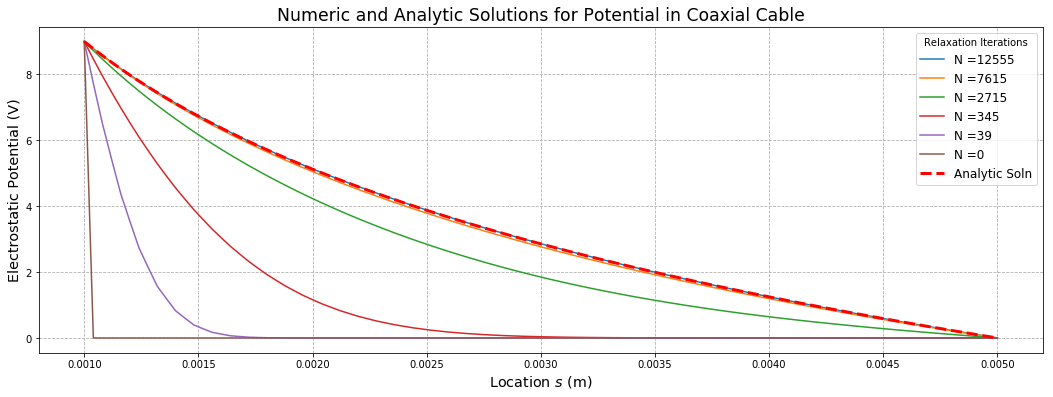

In [22]:
'''Plot Numerical and Analytical Solutions for Coaxial Cable'''
# Define system parameters
V0 = 9.0 # V(s_a) = 9V
s_a, s_b = 0.001, 0.005 # s_a = 1mm and s_b = 5mm

TOLERANCES = np.geomspace(1e-5, 1, num=6) # Array of relaxation tolerances
iteration_counts = [] # List for iterations required to obtain soln within tolerance

plt.figure(figsize=(18, 6)) # Set the plot size

for tol in TOLERANCES:
    cable = CoaxialCable(s_a, s_b, V0, 0.0, 101, tol) # instantiate CoxialCable
    cable.iterate_relaxation() # run relaxation method
    plt.plot(cable.s_vals, cable.v_vals, label='N =' + str(cable.count)) # plot solution

# Calculate analytic solution and plot with dashed line
analytic_potential = analytical_coaxial(cable.s_vals)
plt.plot(cable.s_vals, analytic_potential, linestyle='--', c='r', \
         linewidth=3, label='Analytic Soln')

# Customize plot
plt.legend(title='Relaxation Iterations', fontsize='large')
plt.xlabel('Location $s$ (m)', fontsize='x-large')
plt.ylabel('Electrostatic Potential (V)', fontsize='x-large')
plt.title('Numeric and Analytic Solutions for Potential in Coaxial Cable'\
          , fontsize='xx-large')
plt.grid(linestyle='dashed') # Add grid with dashed lines to graph

plt.show()


This plot shows that, for the specified range of relaxation tolerances, the numeric solution appears to converge to the analytic solution when the relaxation method is allowed to run for more iterations.

In the previous question, we found that running the relaxation for too many iterations resulted in the numeric solution diverging from that of the numeric. We will examine the potential at $s=3~mm$, for a low tolerance, and compare to the analytic solution.

In [23]:
'''Determine Potential at V(s=3mm) and Compare to Expectations'''
cable2 = CoaxialCable(s_a, s_b, V0, 0.0, 101, tol=1e-10) # instantiate CoaxialCable
cable2.iterate_relaxation() # run relaxation method

print('Numerical Solution  V(3mm) =', cable2.v_vals[50], 'V')
print('Analytical Solution V(3mm) =', analytical_coaxial(cable2.s_vals)[50], 'V')

error = error_in_potential(cable2.v_vals, analytical_coaxial(cable2.s_vals))
print('Max error in Solution =', np.amax(error), 'V')


Numerical Solution  V(3mm) = 2.872181636243951 V
Analytical Solution V(3mm) = 2.8565442496261366 V
Max error in Solution = 0.01804513068314595 V


Here, we find that the solution is, at worst, accurate within two decimal places. This value is significantly smaller than the error found in exercise 2 (roughly 1 V max error for tol=1e-10) which is not surprising for two reasons. The first is that the analytic solution for the cable does not require an infinite sum, as does the case of Griffiths example 3.4. The second is that this problem is restricted to one-dimension and we found in the first exercise that there were no issues involved with the solution converging to the expected value.

It should be pointed out that there was an alternative method which could have been used to solve the problem of the coaxial cable. We choose to work with cylindrical coordinates, as this choice would mean a problem in one-dimension. However, it could have been done in cartesian coordinates as well (or any other coordinate system for that matter). Choosing cylindrical coordinates meant that the finite difference equation had to be rederived in cylindrical coordinates. The tradeoff is that implementing the code is theoretically simpler. If cartesian coordinates had been used, no extra work would have been required for the finite difference equation, but the code would not have been so straightforward. After extending the model to two-dimensions in question 2, and having some difficulties, I believe that choosing a coordinate system that allowed for a one-dimensional analysis, was worth the extra preliminary step.

### Conclusion

The introduction of this report mentioned that the goal was to gain experience with computational problem solving in a situation where numeric solutions could be compared to analytic solutions.

In the first question, we solved the Laplace equation in one-dimension using the relaxation method. The results were consistent with our expectations, in that the numeric solution approached the known values for an increased number of operations.

We then applied an extension of this model to the case of two-dimensions. The set-up of the system in two-dimensions was slightly different than the first question, however it was expected that extending the model to two-dimensions would pose no issues apart from slightly more complicated code. After comparing the calculated and expected values for the potential, we noticed that the relaxation method was not converging to the analytic solution for a large number of iterations. This was a totally unexpected, and still not fully understood, result. I believe that the main point/ learning lesson here is that even when the problem is fully understood, and a simple model has been implemented and successfully tested, there is by no means a guarantee that extending the model to a more advanced system will be a success. It would have been extremely easy to over-look the fact that the solution was diverging from expectations if the proper attention hadn't been paid when interpreting the results.

In final part of the report the problem could have been done in one of two ways. We choose the method that restricted the analysis to a single dimension, to stay consistent with the case where we previously had success in our analysis. It may sound obvious, but this will no doubt be a trend moving forward: a good approach to solving a problem is by comparing it to problems that have previously been solved and determining which of these models would fit the problem at hand with the least amount of manipulation. Even in the best situations, we must always be thinking of ways to test the results of our computational analysis.

### References

[1] http://www.cs.unipr.it/~bagnara/Papers/PDF/SIREV95.pdf

[2] https://en.wikipedia.org/wiki/Jacobi_method